## Import Dependencies

In [1]:
%%time

import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc
import itertools
from itertools import combinations_with_replacement, combinations, permutations

import bo_methods_lib
from bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.GPBO_Classes_New import * #Fix this later
from bo_methods_lib.GPBO_Class_fxns import * #Fix this later
import pickle

/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 2.31 s, sys: 303 ms, total: 2.62 s
Wall time: 2.67 s


## Define Method and DateTime

In [2]:
#Generate Method (except last part)
meth_name = Method_name_enum(5)
method = GPBO_Methods(meth_name)

print("Method Name: ", method.method_name.name)
print("Emulator?: ", method.emulator)
print("Obj Func: ", method.obj.name)
print("Sparse Grid?: ", method.sparse_grid)

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
# print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

print(method.method_name.value)

Method Name:  C2
Emulator?:  True
Obj Func:  OBJ
Sparse Grid?:  True
5


## Define Case Study Simulator & Functions

In [3]:
def simulator_helper_test_fxns(cs_name, indecies_to_consider, noise_mean, noise_std, case_study_parameters):
    """
    Sets the model for calculating y based off of the case study identifier.

    Parameters
    ----------
    cs_name: Class, The name/enumerator associated with the case study being evaluated

    Returns
    -------
    calc_y_fxn: function, the function used for calculation is case study cs_name.name
    """
    #Note: Add your function name from GPBO_Class_fxns.py here
    if cs_name.value == 1:      
        theta_names = ['theta_1', 'theta_2']
        bounds_x_l = [-2]
        bounds_x_u = [2]
        bounds_theta_l = [-2, -2]
        bounds_theta_u = [ 2,  2]
        theta_ref = np.array([1.0, -1.0])     
        calc_y_fxn = calc_cs1_polynomial
        
    elif cs_name.value == 2:                          
        theta_names = ['A_1', 'A_2', 'A_3', 'A_4', 'a_1', 'a_2', 'a_3', 'a_4', 'b_1', 'b_2', 'b_3', 'b_4', 'c_1', 
                       'c_2', 'c_3', 'c_4', 'x0_1', 'x0_2', 'x0_3', 'x0_4', 'x1_1', 'x1_2', 'x1_3', 'x1_4']
        bounds_x_l = [-1.5, -0.5]
        bounds_x_u = [1, 2]
        bounds_theta_l = [-300,-200,-250, 5,-2,-2,-10, -2, -2,-2,5,-2,-20,-20, -10,-1 ,-2,-2,-2, -2,-2,-2,0,-2]
        bounds_theta_u = [-100,  0, -150, 20,2, 2, 0,  2,  2,  2, 15,2, 0,0   , 0,  2, 2,  2, 2, 2 ,2 , 2, 2,2]
        theta_ref = np.array([-200,-100,-170,15,-1,-1,-6.5,0.7,0,0,11,0.6,-10,-10,-6.5,0.7,1,0,-0.5,-1,0,0.5,1.5,1])      
#         theta_ref = np.array([0.5, 0.5, 0.8, 2/3, 0.25, 0.25, 0.35, 0.675, 0.5, 0.5, 0.6, 0.65, 0.5, 0.5, 0.35, 28333/50000, 0.75, 0.5,
#     0.375, 0.25, 0.5, 0.625, 0.75, 0.75])
        calc_y_fxn = calc_muller
        
    else:
        raise ValueError("self.CaseStudyParameters.cs_name.value must exist!")

    return Simulator(indecies_to_consider, 
                     theta_ref,
                     theta_names,
                     bounds_theta_l, 
                     bounds_x_l, 
                     bounds_theta_u, 
                     bounds_x_u, 
                     noise_mean,
                     noise_std,
                     case_study_parameters,
                     calc_y_fxn)

## Define Case Study

In [4]:
cs_name  = CS_name_enum(1)
print("CS Name: ", cs_name.name)

# indecies_to_consider = list(range(4, 12)) #This is what changes for different subproblems of CS2
indecies_to_consider = list(range(0, 2)) #This is what changes for different subproblems of CS1

ep0 = 1
ep_enum = Ep_enum(1)
sep_fact = 0.8
normalize = False
eval_all_pairs = False
noise_mean = 0
noise_std = 0.01
# noise_std = 0.0
kernel = Kernel_enum(1)
lenscl = None
outputscl = 1
retrain_GP = 0
GP_train_iter = 300
bo_iter_tot = 3
bo_run_tot = 2
save_data = False
num_data = None
seed = 1
ei_tol = 1e-6
obj_tol = 1e-4

cs_params = CaseStudyParameters(cs_name, ep0, sep_fact, normalize, eval_all_pairs, bo_iter_tot, bo_run_tot, 
                                save_data, DateTime, seed, ei_tol, obj_tol)

simulator = simulator_helper_test_fxns(cs_name, indecies_to_consider, noise_mean, noise_std, cs_params)

CS Name:  CS1


## Generate Experimental X and Y Data (If not given)

In [5]:
#Test gen_exp_data
num_x_data = 5
gen_meth_x = Gen_meth_enum(2) #Note: Has to be the same for validation and sim data
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x)
# print(exp_data.theta_vals, exp_data.x_vals)
# print(exp_data.y_vals)

## Generate Simulation Training/Testing Theta and y Data

In [6]:
num_theta_data = 5
gen_meth_theta = Gen_meth_enum(2)
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x)
print(len(sim_data.theta_vals))
sim_sse_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data)
print(len(sim_sse_data.x_vals))

125
5


## Generate Validation Data

In [7]:
num_theta_data_val = 11 #How to make the seed different for generating validation data?
gen_meth_theta_val = Gen_meth_enum(1)
val_data = simulator.gen_sim_data(num_theta_data_val, num_x_data, gen_meth_theta_val, gen_meth_x, True)
val_sse_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, True)
    
print(val_sse_data.x_vals[0:10])

[[-2.]
 [-1.]
 [ 0.]
 [ 1.]
 [ 2.]]


## Create Normalized Data (optional)

In [8]:
#What is the best way to be building normalized data? Is it ok to write a method in a class that calls itself?
# scaled_exp_data = exp_data.norm_feature_data()
# scaled_sim_data = sim_data.norm_feature_data()
# scaled_val_data = val_data.norm_feature_data()
    
# #Q: How do I best automate which one of these to use? Where would I automate this?
# #A: GPBO_Driver
# print(scaled_exp_data.x_vals)

## Calculate Current Exploration Bias

In [9]:
ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, None, None, None, None, None)
ep_bias.set_ep()

## Initialize Driver

In [10]:
ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, None, None, None, None, None)
driver = GPBO_Driver(cs_params, method, simulator, exp_data, sim_data, sim_sse_data, val_data, val_sse_data, None, ep_bias)
driver.ep_bias.set_ep()

## Build GP Emulator Class

In [11]:
gp_emulator = driver.gen_emulator(kernel, lenscl, outputscl, retrain_GP)
print(gp_emulator.get_num_gp_data())

125


## Generate, Shuffle, and Split Training Data

In [12]:
#Q: Need this to get training indecies based on emulator status
#A: Call train test split in driver
train_data, test_data = gp_emulator.set_train_test_data(cs_params)
# print(gp_emulator.__feature_train_data)
# print(train_data.theta_vals)

## Set GP Model

In [13]:
# print(gp_emulator.feature_train_data)
gp_model = gp_emulator.set_gp_model()

## Train GP Model

In [14]:
gp_emulator.train_gp(gp_model)

In [15]:
print(gp_emulator.trained_hyperparams)

[array([4.07832136, 2.1882075 , 0.65211112]), 0.0001, 1]


## Evaluate GP Model Mean and Variance

## Evaluate GP SSE and SSE_var

## Calculate Best Error

## Calculate EI

## Optimize EI over theta

## Augmenting Training Data (Skipped Steps)

# Case Study GPBO Driver Test

In [16]:
cs_name  = CS_name_enum(2)
name_cs_str = cs_name.name
print("CS Name: ", name_cs_str)

indecies_to_consider = list(range(0, 8)) #This is what changes for different subproblems of CS2
# indecies_to_consider = list(range(0, 2)) #This is what changes for different subproblems of CS1

ep0 = 1
ep_enum = Ep_enum(1)
sep_fact = 0.8
normalize = False
gen_heat_map_data = True
noise_mean = 0
noise_std = 0.01
# noise_std = 0.0
kernel = Kernel_enum(1)
lenscl = None
outputscl = 1
retrain_GP = 0
GP_train_iter = 300
bo_iter_tot = 5
bo_run_tot = 2
save_data = False
num_data = None
seed = 1
ei_tol = 1e-6
obj_tol = 1e-4

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

#Set Cs_params and Simulator
cs_params = CaseStudyParameters(cs_name, ep0, sep_fact, normalize, gen_heat_map_data, bo_iter_tot, bo_run_tot, 
                                save_data, DateTime, seed, ei_tol, obj_tol)

simulator = simulator_helper_test_fxns(cs_name, indecies_to_consider, noise_mean, noise_std, cs_params)

CS Name:  CS2


In [17]:
#Set Method
meth_name = Method_name_enum(1)
method = GPBO_Methods(meth_name)
print(method.method_name.name)

#Generate Exp Data
num_x_data = 5
gen_meth_x = Gen_meth_enum(2) #Note: Has to be the same for validation and sim data
exp_data = simulator.gen_exp_data(num_x_data, gen_meth_x)

#Generate Sim Data
num_theta_data = 100
gen_meth_theta = Gen_meth_enum(1)
sim_data = simulator.gen_sim_data(num_theta_data, num_x_data, gen_meth_theta, gen_meth_x)
sim_sse_data = simulator.sim_data_to_sse_sim_data(method, sim_data, exp_data)

#Generate Validation Data
num_theta_data_val = 10
gen_meth_theta_val = Gen_meth_enum(1)
val_data = simulator.gen_sim_data(num_theta_data_val, num_x_data, gen_meth_theta_val, gen_meth_x, True)
val_sse_data = simulator.sim_data_to_sse_sim_data(method, val_data, exp_data, True)

#Initialize Driver
ep_bias = Exploration_Bias(ep0, None, ep_enum, None, None, None, None, None, None, None)
driver = GPBO_Driver(cs_params, method, simulator, exp_data, sim_data, sim_sse_data, val_data, val_sse_data, None, ep_bias)

A1


In [18]:
#Run Bo iterations/restarts
reoptimize = 10
restart_bo_results = driver.run_bo_restarts(kernel, lenscl, outputscl, retrain_GP, reoptimize)

In [19]:
driver.save_data(restart_bo_results)

In [20]:
fileObj = open("No_Date/Data_Files/" + name_cs_str + ".pickle", 'rb')
loaded_results = pickle.load(fileObj)
fileObj.close()

print(loaded_results[0].configuration)
print(loaded_results[0].list_gp_emulator_class[0])
# print(len(loaded_results[0].list_heat_map_data))
print(loaded_results[0].results_df)
print(loaded_results[0].results_df["Theta Min Obj Cum."].iloc[-1])
print(loaded_results[0].simulator_class.theta_true)
# print(loaded_results[0].simulator_class.theta_true_norm)

{'DateTime String': None, 'Method Name Enum Value': 1, 'Case Study Name': 'CS2', 'Exploration Bias Method Value': 1, 'Separation Factor': 0.8, 'Normalize': False, 'Heat Map Points Generated': True, 'Max BO Iters': 5, 'Number of Workflow Restarts': 2, 'Seed': 3, 'EI Tolerance': 0.0001, 'Obj Improvement Tolerance': 1e-06}
   index    Best Error Exploration Bias        Max EI  \
0      0  93882.945784                1  93882.945784   
1      0  93882.945784                1  93882.945784   

                                        Theta Max EI Min Obj  \
0  [-220.39821497674842, -96.65993928376841, -150...     0.0   
1  [-117.84480219933286, -172.27433876805173, -24...     0.0   

                                       Theta Min Obj Min Obj Cum.  \
0  [-220.39821497674842, -96.65993928376841, -150...          0.0   
1  [-285.2322426849863, -105.96982286828248, -178...          0.0   

                                  Theta Min Obj Cum. Time/Iter  
0  [-220.39821497674842, -96.65993928376

## Plot Data and Make Heat Maps

In [21]:
from bo_methods_lib.GPBO_Classes_plotters import *
runs = len(loaded_results)
dim_hps = len(loaded_results[0].list_gp_emulator_class[0].trained_hyperparams[0]) + 2
num_hp_sets = len(loaded_results[0].list_gp_emulator_class)
hps = np.zeros((runs, num_hp_sets, dim_hps))
hp_names = [f"\\ell_{i}" for i in range(1, dim_hps+1)]
hp_names[-2] = "\sigma"
hp_names[-1] = "\\tau"

for j in range(runs):
    run = loaded_results[j]
    for i in range(len(run.list_gp_emulator_class)):
       # Extract the array and convert other elements to float
        array_part = run.list_gp_emulator_class[i].trained_hyperparams[0]
        rest_part = np.array(run.list_gp_emulator_class[i].trained_hyperparams[1:], dtype=float)

        # Create the resulting array of shape (1, 10)
        hps[j,i] = np.concatenate([array_part, rest_part])
    
print(hps)

[[[1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e-04 1.e+00]
  [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e-04 1.e+00]]

 [[1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e-04 1.e+00]
  [1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e+00 1.e-04 1.e+00]]]


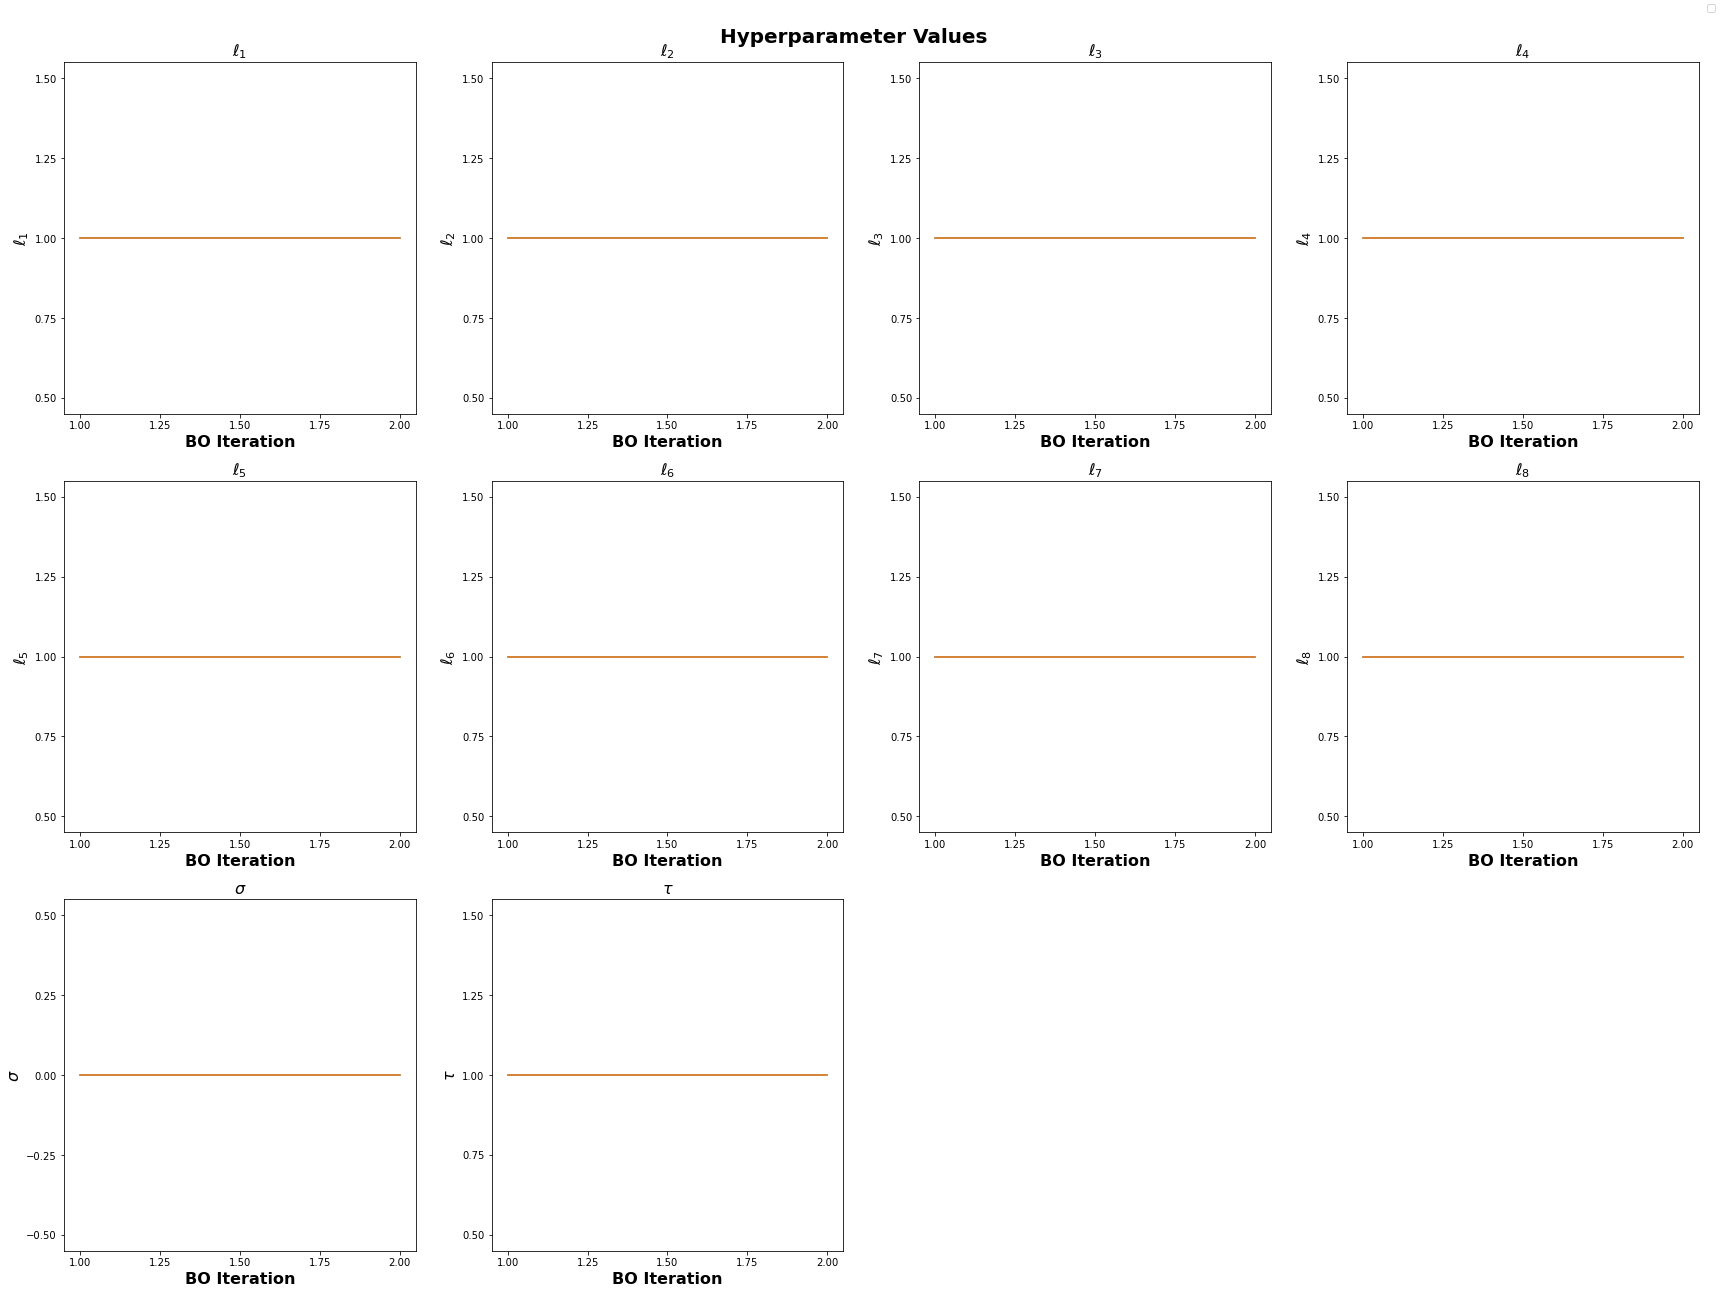

In [22]:
xbins = 5
ybins = 5
title_fontsize = 20
other_fontsize = 16
plot_hypers(hps, hp_names, xbins, ybins, title_fontsize, other_fontsize)